In [1]:
#Imports
import re
import time
import sqlite3
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pycountry
#Froms
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
#Primeiras configurações
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
#Conexão ao Banco
conDB = sqlite3.connect('imdb.db')

In [2]:
#Functions
def generos_list(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer( token_pattern = '(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    generos = vetor.get_feature_names()
    generos =[ genre for genre in generos if len(genre) > 1 ]
    return generos

In [3]:
#SQLs
sql_Names_Tables='''SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type='table' ''' 
sql_Title ='''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''
sql_Genres_Qtd ='''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres '''
sql_Ratings_Genres ='''SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type ='movie' '''
sql_Ratings_Premiered ='''SELECT rating AS Ratings, premiered FROM ratings JOIN  titles ON  ratings.title_id = titles.title_id WHERE premiered <=2020 AND type='movie' ''' 
sql_Genres= '''SELECT genres FROM titles'''
sql_Runtime_Title = ''' SELECT runtime_minutes Runtime, primary_title FROM titles WHERE type='movie' AND Runtime !='NaN' '''
sql_Runtime_Title_L1 = ''' SELECT runtime_minutes Runtime, primary_title FROM titles WHERE type='movie' AND Runtime !='NaN' ORDER BY Runtime DESC LIMIT 1 '''
sql_Runtime_Genres = ''' SELECT runtime_minutes runtime, genres FROM titles WHERE type='movie' AND runtime != 'NaN' GROUP BY genres '''
sql_Region_Qtd = '''SELECT region,COUNT(*) Number_of_Movie FROM akas JOIN titles ON akas.title_id = titles.title_id WHERE type ='movie' AND region != 'None' GROUP BY region '''
sql_Title_Ratings_Genres_L10DESC ='''SELECT primary_title AS Movie_Name, genres, rating FROM titles JOIN ratings ON titles.title_id = ratings.title_id WHERE titles.type='movie' AND ratings.votes > 25000 ORDER BY rating DESC LIMIT 10'''
sql_Title_Ratings_Genres_L10ASC ='''SELECT primary_title AS Movie_Name, genres, rating FROM titles JOIN ratings ON titles.title_id = ratings.title_id WHERE titles.type='movie' AND ratings.votes > 25000 ORDER BY rating ASC LIMIT 10'''


In [4]:
#Query
q_Tables_Names = pd.read_sql_query(sql_Names_Tables,conDB)
q_Title = pd.read_sql_query(sql_Title,conDB)
q_Genres = pd.read_sql_query(sql_Genres,conDB)
q_Genres_Qtd = pd.read_sql_query(sql_Genres_Qtd,conDB)
q_Ratings_Premiered = pd.read_sql_query(sql_Ratings_Premiered,conDB)
q_Runtime_Title = pd.read_sql_query(sql_Runtime_Title,conDB)
q_Runtime_Title_L1 = pd.read_sql_query(sql_Runtime_Title_L1,conDB)
q_Region_Qtd = pd.read_sql_query(sql_Region_Qtd,conDB)
q_Title_Ratings_Genres_L10DESC = pd.read_sql_query(sql_Title_Ratings_Genres_L10DESC,conDB)
q_Title_Ratings_Genres_L10ASC = pd.read_sql_query(sql_Title_Ratings_Genres_L10ASC,conDB)

In [5]:
#Variáveis Global
rg_expressao ='(?u)\\b[\\w-]+\\b'
generos= generos_list(q_Genres)

In [6]:
#Esquemas de Tabelas
tbs_Banco = q_Tables_Names['Table_Name'].values.tolist()
for tb_Banco in tbs_Banco:
    consulta = "PRAGMA TABLE_INFO({})".format(tb_Banco)
    resultado = pd.read_sql_query(consulta,conDB)
    print('Esquema da Tabela:',tb_Banco)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da Tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




In [7]:
# Tables Genes com %
q_Title['percentual'] = (q_Title['COUNT'] / q_Title['COUNT'].sum()) * 100
display(q_Title)

,type,COUNT,percentual
0,movie,607342,6.860955
1,short,864919,9.770723
2,tvEpisode,6640383,75.014361
3,tvMiniSeries,43007,0.485837
4,tvMovie,135731,1.533311
5,tvPilot,2,0.000023
6,tvSeries,223550,2.525375
7,tvShort,10519,0.118830
8,tvSpecial,36557,0.412973
9,video,259250,2.928667


In [8]:
#Filter 5 maiores, junção dos Outros Geners com Others
others_Genres ={}
others_Genres['COUNT'] = q_Title[ q_Title['percentual'] < 5 ] ['COUNT'].sum()
others_Genres['percentual'] = q_Title[ q_Title['percentual'] < 5 ] ['percentual'].sum()
others_Genres['type'] = 'others'
#Filtrando apenas os cinco maiores 
q_Title = q_Title[q_Title['percentual'] > 5]
#Add Others na lista
q_Title =q_Title.append(others_Genres, ignore_index=True)
q_Title = q_Title.sort_values(by='COUNT',ascending = False )
q_Title.head()

,type,COUNT,percentual
2,tvEpisode,6640383,75.014361
1,short,864919,9.770723
3,others,739505,8.353960
0,movie,607342,6.860955


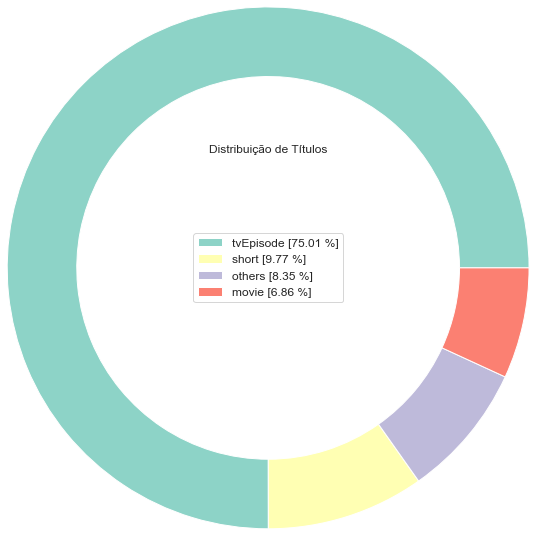

In [9]:
#Criando variavel label e usando o list compreshesion
labels_Genres = [str(q_Title['type'][i])+' '+'['+ str(round(q_Title['percentual'][i],2))+' %'+']' for i in q_Title.index ]
#Cores Maps
cs = cm.Set3(np.arange(100))
#Figure Create
plt.figure()
plt.pie(q_Title['COUNT'], labeldistance=1,radius=3,colors=cs,wedgeprops = dict(width=0.8))
plt.legend(labels= labels_Genres, loc='center', prop={'size':12})
plt.title("Distribuição de Títulos", loc="center", fontdict={'fontsize':12,'fontweight':20})
plt.show()

In [10]:
display(q_Genres_Qtd) # Geners por quantidades.

,genres,COUNT(*)
0,Action,13970
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1454,"Thriller,Western",43
1455,War,1292
1456,"War,Western",14
1457,Western,5151


In [11]:
m_GenersQtds = []
for g in generos:
    sql ="SELECT COUNT(*) AS qtd FROM titles WHERE genres LIKE '%"+g+"%' AND type='movie'"
    result = pd.read_sql_query(sql,conDB)
    m_GenersQtds.append(result['qtd'].values[0])

In [12]:
q_Genres_Qtd['genres'] =q_Genres_Qtd['genres'].str.lower().values
temp_Genres_Qtd = q_Genres_Qtd['genres'].dropna()
vetor =  CountVectorizer(token_pattern=rg_expressao, analyzer='word').fit(generos)
bag_genres = vetor.transform(temp_Genres_Qtd)
name_Genres = vetor.get_feature_names()
df_Genres_Qtd = pd.DataFrame(bag_genres.todense(),columns=name_Genres,index=temp_Genres_Qtd.index)
#df_Genres_Qtd = df_Genres_Qtd.drop(columns='n')
generos_percentual = 100 * pd.Series(df_Genres_Qtd.sum()).sort_values(ascending=False) / df_Genres_Qtd.shape[0]

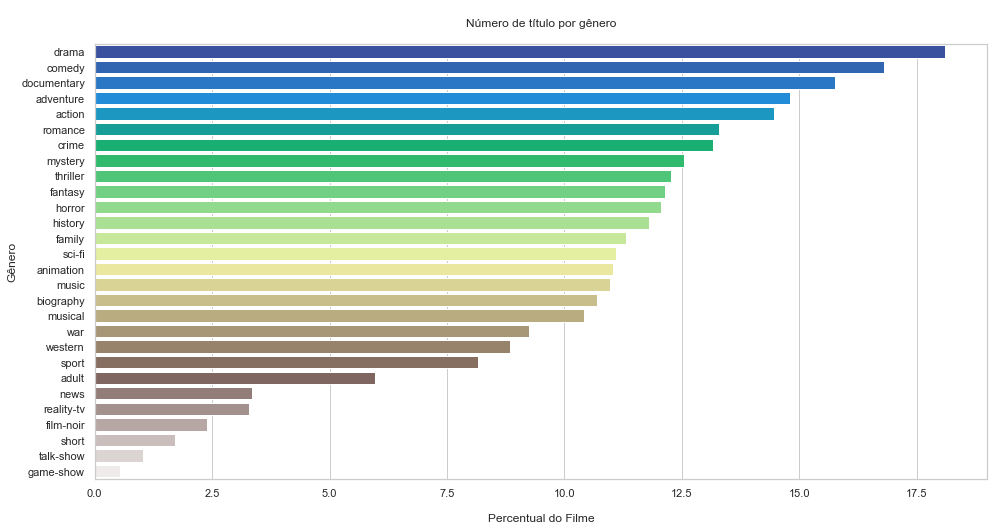

In [13]:
#Plot
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient = 'h', palette='terrain')
plt.ylabel("Gênero")
plt.xlabel("\nPercentual do Filme")
plt.title("\nNúmero de título por gênero\n")
plt.show()

In [14]:
m_Rating = []
m_RatingCount =[]

for item in generos:
    consult = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%"+item+"%' AND type='movie'"
    result = pd.read_sql_query(consult,conDB)
    m_RatingCount.append(result.values[0][0])
    
    consult ="SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%"+item+"%' AND type='movie'"
    result = pd.read_sql_query(consult,conDB)
    m_Rating.append(np.median(result['rating']))

In [15]:
df_RatingGenero =  pd.DataFrame()
df_RatingGenero['genres'] = generos
df_RatingGenero['count'] = m_RatingCount
df_RatingGenero['rating'] = m_Rating

df_RatingGenero = df_RatingGenero.drop(index=18)
df_RatingGenero = df_RatingGenero.sort_values(by='rating', ascending=False)

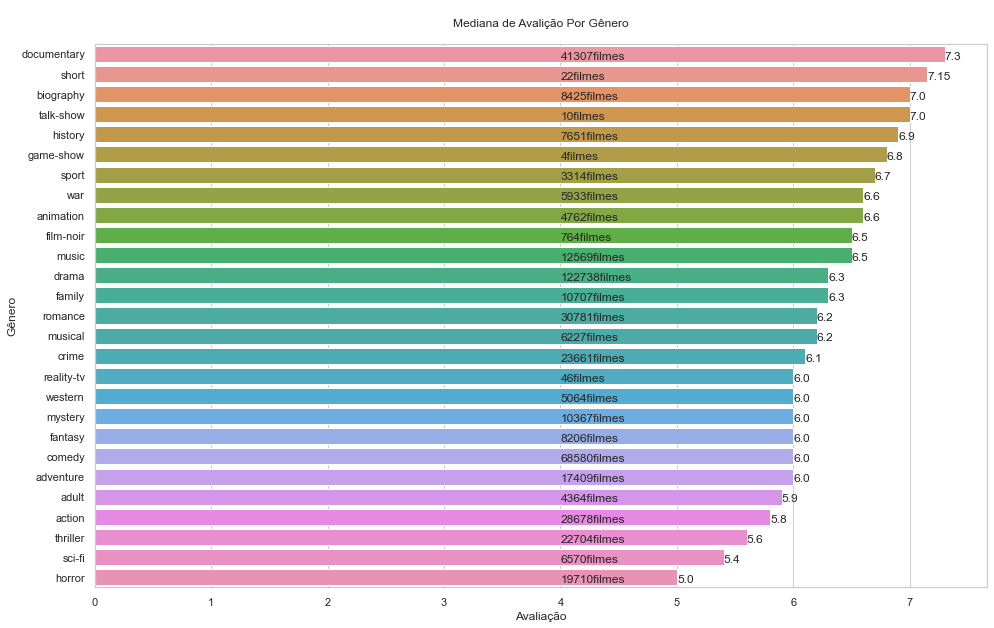

In [16]:
plt.figure(figsize=(16,10))
sns.barplot(y= df_RatingGenero.genres, x= df_RatingGenero.rating, orient='h')
for i in range(len(df_RatingGenero.index)):
    plt.text(4.0,
             i + 0.25, 
             str(df_RatingGenero['count'][df_RatingGenero.index[i]])+'filmes')    
    plt.text(df_RatingGenero.rating[df_RatingGenero.index[i]],
             i + 0.25,
             round(df_RatingGenero['rating'][df_RatingGenero.index[i]],2))

plt.ylabel("Gênero")
plt.xlabel("Avaliação")
plt.title('\nMediana de Avalição Por Gênero\n')
plt.show()

In [17]:
m_RatingsPremiered = []
for year in set(q_Ratings_Premiered['premiered']):
    m_RatingsPremiered.append( np.median( q_Ratings_Premiered[q_Ratings_Premiered['premiered'] == year]['Ratings']))
m_RatingsPremiered[1:10]
anos_RatingsPremiered = list(set(q_Ratings_Premiered['premiered']))

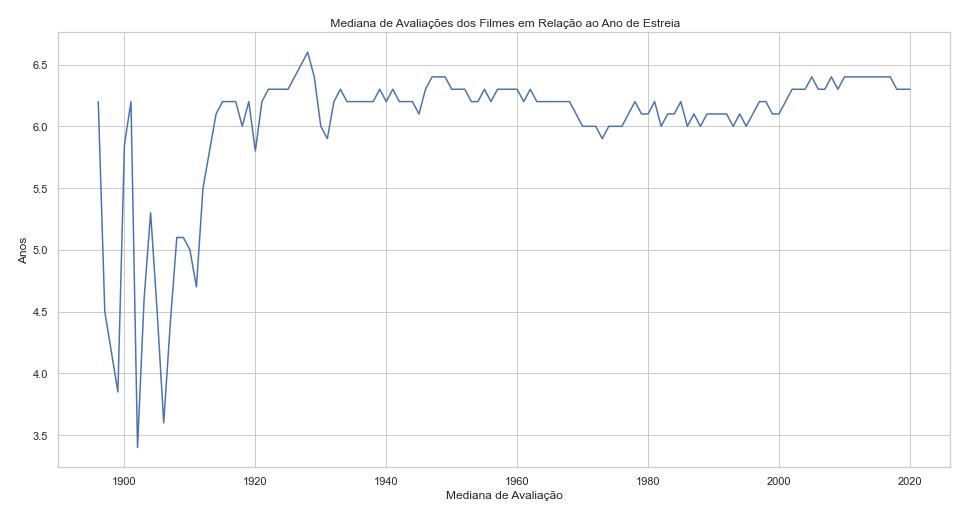

In [18]:
plt.figure(figsize=(16,8))
plt.plot(anos_RatingsPremiered,m_RatingsPremiered)
plt.ylabel('\nAnos')
plt.xlabel('Mediana de Avaliação')
plt.title('\n Mediana de Avaliações dos Filmes em Relação ao Ano de Estreia')
plt.show()

In [19]:
#exemplo de Percetitle
for i in range(101):
    val = i 
    per = round(np.percentile(q_Runtime_Title['Runtime'].values,val),2)
    print('{} percentual de duração (runtime) é : {}'.format(val,per))

0 percentual de duração (runtime) é : 1.0
1 percentual de duração (runtime) é : 45.0
2 percentual de duração (runtime) é : 47.0
3 percentual de duração (runtime) é : 50.0
4 percentual de duração (runtime) é : 50.0
5 percentual de duração (runtime) é : 51.0
6 percentual de duração (runtime) é : 52.0
7 percentual de duração (runtime) é : 53.0
8 percentual de duração (runtime) é : 55.0
9 percentual de duração (runtime) é : 56.0
10 percentual de duração (runtime) é : 58.0
11 percentual de duração (runtime) é : 59.0
12 percentual de duração (runtime) é : 60.0
13 percentual de duração (runtime) é : 60.0
14 percentual de duração (runtime) é : 60.0
15 percentual de duração (runtime) é : 61.0
16 percentual de duração (runtime) é : 63.0
17 percentual de duração (runtime) é : 65.0
18 percentual de duração (runtime) é : 66.0
19 percentual de duração (runtime) é : 68.0
20 percentual de duração (runtime) é : 69.0
21 percentual de duração (runtime) é : 70.0
22 percentual de duração (runtime) é : 70.0

In [20]:
q_Runtime_Title_L1

,Runtime,primary_title
0,51420,Logistics


In [21]:
m_RuntimeMedian = []

for item in generos:
    sql = "SELECT runtime_minutes FROM titles WHERE type='movie' AND genres LIKE '%"+item+"%' AND runtime_minutes != 'NaN'"
    c = pd.read_sql_query(sql,conDB)
    m_RuntimeMedian.append(np.median(c['runtime_minutes']))

df_GeneroRuntime = pd.DataFrame()
df_GeneroRuntime['genres'] = generos
df_GeneroRuntime['runtime'] =m_RuntimeMedian

df_GeneroRuntime = df_GeneroRuntime.drop(index=18)
df_GeneroRuntime = df_GeneroRuntime.sort_values(by='runtime',ascending=False)

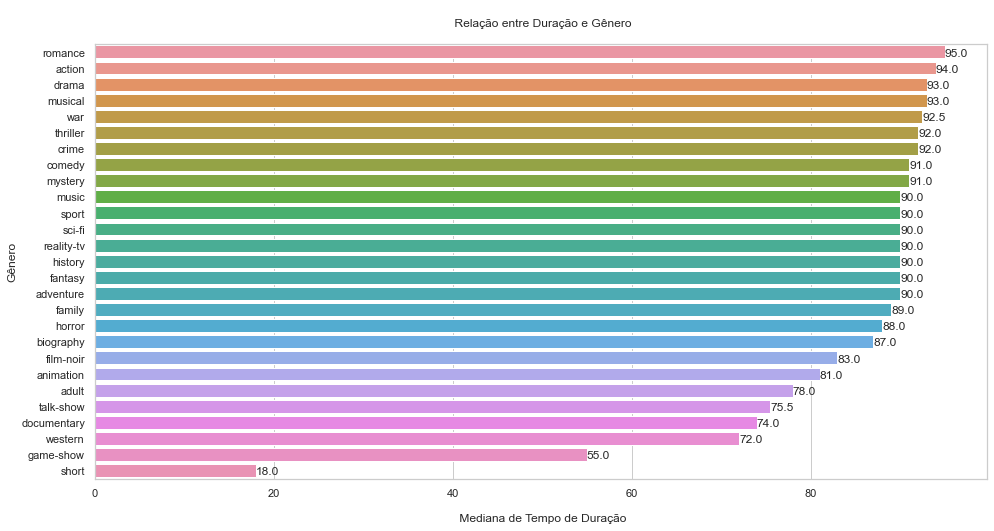

In [22]:
#Plt
plt.figure(figsize=(16,8))
sns.barplot(y=df_GeneroRuntime.genres,x=df_GeneroRuntime.runtime,orient='h')

for i in range(len(df_GeneroRuntime.index)):
    plt.text(df_GeneroRuntime.runtime[df_GeneroRuntime.index[i]], 
             i + 0.25 , 
             round(df_GeneroRuntime['runtime'][df_GeneroRuntime.index[i]],2))
    
plt.ylabel('Gênero')
plt.xlabel('\n Mediana de Tempo de Duração')
plt.title('\n Relação entre Duração e Gênero\n')
plt.show()

In [23]:
m_Paises =[]
m_PaisesCount = []

for i in range(q_Region_Qtd.shape[0]):
    try:
        coun = q_Region_Qtd['region'].values[i]
        m_Paises.append(pycountry.countries.get(alpha_2 = coun).name)
        m_PaisesCount.append(q_Region_Qtd['Number_of_Movie'].values[i])
    except:
        continue

In [24]:
df_PaisesQtde = pd.DataFrame()
df_PaisesQtde['region'] = m_Paises
df_PaisesQtde['Movie_count'] =m_PaisesCount
df_PaisesQtde =df_PaisesQtde.sort_values(by='Movie_count',ascending=False)
df_PaisesQtde.head(10)

,region,Movie_count
199,United States,310424
65,United Kingdom,159351
96,Japan,91266
63,France,84602
89,India,80877
32,Canada,77539
47,Germany,70699
26,Brazil,65435
93,Italy,65339
58,Spain,65311


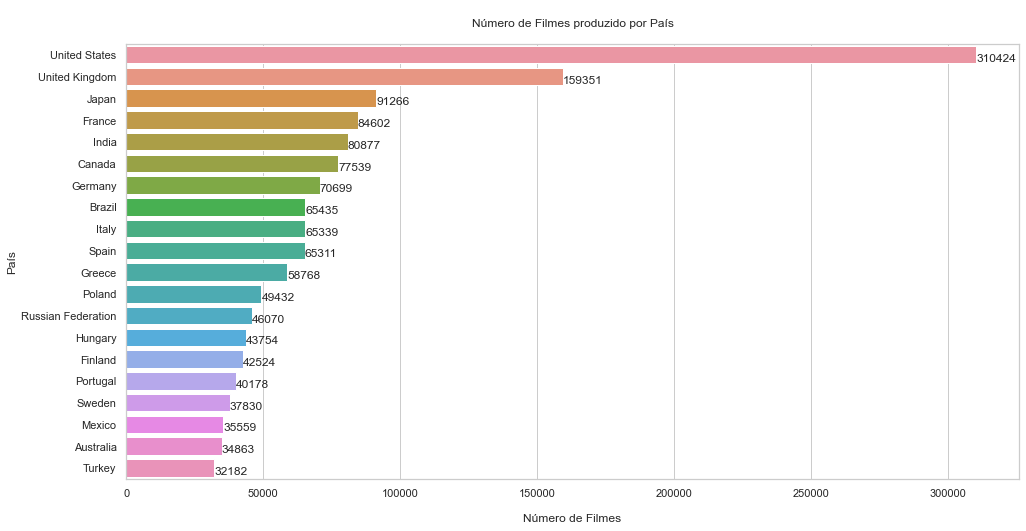

In [25]:
plt.figure(figsize=(16,8))
sns.barplot(y=df_PaisesQtde[:20].region,x=df_PaisesQtde[:20].Movie_count,orient='h')
for i in range(0,20):
    plt.text(df_PaisesQtde.Movie_count[df_PaisesQtde.index[i]], 
             i + 0.30 , 
             round(df_PaisesQtde['Movie_count'][df_PaisesQtde.index[i]],2))    
plt.ylabel('País')
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes produzido por País\n')
plt.show()

In [26]:
display(q_Title_Ratings_Genres_L10ASC) #Top Filmes Ruins

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.1
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
4,Manos: The Hands of Fate,Horror,1.6
5,Reis,"Biography,Drama",1.6
6,The Cost of Deception,"Crime,Drama,History",1.7
7,Justin Bieber: Never Say Never,"Documentary,Music",1.7
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9


In [27]:
display(q_Title_Ratings_Genres_L10DESC) #Top Filmes Bons

,Movie_Name,genres,rating
0,Jai Bhim,"Crime,Drama,Mystery",9.4
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.2
5,Mirror Game,"Crime,Mystery,Thriller",9.2
6,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,Schindler's List,"Biography,Drama,History",9.0
